### Verificação de Algoritmos

In [1]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics.pairwise import (
    cosine_similarity, 
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    sigmoid_kernel, 
    chi2_kernel,
    polynomial_kernel,
    rbf_kernel
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, v_measure_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.cluster import SpectralClustering

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp()

In [3]:
textos = [
    (clean_up.fit("Sou alérgica! Tenho Rinite e Sinusite! Então: Eu tenho Tosse, eu espirro, eu tenho coriza, meu nariz é sempre entupido, eu tenho falta de ar, eu me sinto cansada, eu fico estressada, eu fico sem sentir cheiro das coisas, eu sinto dor de cabeça! Mas não estou com corona vírus!"), 0),
    (clean_up.fit("Pq toda vez que eu vejo isso me dá um aperto no peito e uma falta de ar? Pq tem que doer?"), 0),
    (clean_up.fit("Se eu ver alguém com falta de ar, eu fico juntinho da agonia. Do nada eu tô respirando igual"), 0),
    (clean_up.fit("Conheça agora o início da trajetória e da cruzada sanitarista do homem que viria a curar um Brasil enfermo, erradicando a febre amarela, a peste bubônica e a varíola. O INÍCIO DA CRUZADA DE OSWALDO CRUZ - EDUARDO BUENO Oswaldo Cruz foi o médico e monstro. Monstro sagrado da ciência! Médico autoritário, capaz de agir como um autêntico ditador! Conheça agora o início da traje... youtube.com"), 0),
    (clean_up.fit("Eu tava no supermercado com a minha mãe lá de boas e do nada comecei a ficar com falta de ar, eu não sabia se era a mascara me incomodando, se era crise de ansiedade ou se era coronavírus, mas foi muito assustador"), 0),
    (clean_up.fit("Ontem tomei a vacina que me derrubou, me deu uma febre do caralho"), 0),
    (clean_up.fit("quem que vai pro cinema com febre??"), 0),
    (clean_up.fit("Não posso ouvir a palavra ¨respirador¨que já me dá falta de ar"), 0),
    (clean_up.fit("tem depressão? sorria!  tem anorexia? coma!  tá com falta de ar? respire!  tem ansiedade? acalme!  está com coronavírus? tome remédio!  é surdo? ouça! é gorda? pare de comer!  é assexual? transe!  é cego? enxergue  é gay? se cure   a vida é muito simples, você que complica!"), 0),
    (clean_up.fit("6. Caso apresente algum sintoma, vá ao posto de saúde do seu bairro, apresentando cartão do sus.  Sintomas: -Tosse -Febre  -Coriza  -Dor de garganta -Dificuldade para respirar"), 0),
    (clean_up.fit("Se 3/4 dessa manada se contaminar c febre aftosa eu já me dou por satisfeito."), 0),
    (clean_up.fit("tem depressão? sorria! ta com falta de ar? respire! tem ansiedade? acalme! é surdo? ouça! é gay? se cure! é aleijado? ande!"), 0),
    (clean_up.fit("odeio quando minha rinite ataca, odeio ter rinite, odeio ter sinusite, odeio ter falta de ar"), 0),
    (clean_up.fit("ai que ignorância podre alguém tosse na cara dela"), 0),
    (clean_up.fit("PEGUEI COVID-16. ESCAPEI POR POUCO"), 0),
    (clean_up.fit("falta de ar e insônia eu não desejo pra ninguém"), 0),
    (clean_up.fit("estou com frio porque tá frio ou porque estou com febre?todo dia a mesma paranoia"), 0),
    (clean_up.fit("Eu na quarentena:  (Não estou com covid-19) em São Paulo, Brazil"), 0),
    (clean_up.fit("Estava comentando c as meninas no grupo sobre o fato que já era p ter uma vacina contrar o corona vírus mano eles estão demorando p descobrir hein pqp, sarampo/febre amarela/ dengue foram rapidinho"), 0),
    (clean_up.fit("Tanta saudade de ir para a igreja"), 0),
    (clean_up.fit("Será q estou com COVID-19? O Min. da Saúde alerta pra q acaso você sinta falta de ar procure um hospital. Toda vez que olho suas fotos eu sinto essa tal falta de ar, ela vem junto com umas borboletas no estômago e uma febre adolescente. Acho que estou doente, mas talvez seja amor"), 0),
    (clean_up.fit("é deliciosa a sensação de se sentir febril sem ta com febre pq não sabe se tem algo acontecendo ou tu so é doida"), 0),
    (clean_up.fit("Ser uma jovem que se alimenta mal e sentir falta de ar em 2020 é não saber se é veias entupidas, covid ou ansiedade Sinceramente não sei qual o pior só queria q os ET viessem logo"), 0),
    
    (clean_up.fit("00:20 e eu com garganta inflamada, febre e sem conseguir dormir respondendo pergunta de aluno uma hora dessas.. não façam isso crianças"), 1),
    (clean_up.fit("Eu simplesmente tô desesperada... Minha avó tá com suspeita de Covid-19 Ela está muito mal mesmo... a febre tá alta...  Eu estou entrando em crise..."), 1),
    (clean_up.fit("gente eu peguei COVID            COnstantemente e                    inVolutariamente pensando e             Imaginando aquele rabão             Do jacob"), 1),
    (clean_up.fit("Peguei covid-19 mais estou bem"), 1),
    (clean_up.fit("Febre foi longe demais agora"), 1),
    (clean_up.fit("To cheia de febre"), 1),
    (clean_up.fit("gente a boa notícia de hoje pra quem gosta de mim é que meu olfato ta voltando e a dor de cabeça passou não é hoje que o corona me mata"), 1),
    (clean_up.fit("a, estou muito quente ;-;  acho que tô com febre ;-;"), 1),
    (clean_up.fit("Taí um sintoma que eu, que estou com Covid-19 (13 dias de sintomas) mas nem tossi, tive.  Aliás, perda de olfato parcial é fácil de detectar, vc sente gosto metálico ou 'de talco' na boca, e o cheiro das coisas fica estranho.  PORÉM também é sintoma de sinusite."), 1),
    (clean_up.fit("fui falar pra minha mãe que eu estava com o nariz entupido e agora ela está achando que estou com covid-"), 1),
    (clean_up.fit("Tomando o cimegripe, vamos descobrir se estou com covid-19 ou nao!!!! (Sim ja estou a 9 dias de quarentena desde q comecei a espirrar)"), 1),
    (clean_up.fit("Estou com covid-19 :(  O que tá rolando?"), 1),
    (clean_up.fit("Mano, acordei com uma crise de tosse horrível."), 1),
    (clean_up.fit("Tô sentindo muita falta de ar pqp"), 1),
    (clean_up.fit("minha sobrinha está internada por causa de febre, que Jesus a proteja"), 1),
    (clean_up.fit("pergunta corona Estou com cansaço e meio febril, posso estar com covid?"), 1),
    (clean_up.fit("véi eu tbm to doente, minha cabeça tá a ponto de explodir, tive febre e tudo"), 1),
    (clean_up.fit("Bom dia pra qm acordou gripada e com febre"), 1),
    (clean_up.fit("meu deus eu to com falta de ar?"), 1),
    (clean_up.fit("fui dormir c febre e acordei c o nariz sangrando"), 1),
    (clean_up.fit("'tia não saia de casa pelo amor de Deus eu to muito preocupada etc etc qualquer coisa me avisa, liga pra mim' titia hj: ah minha filha, todo mundo aqui pegou eu acho, tudo com febre e tosse sem sentir cheiro de nada. Não queria te preocupar. Tomei chá de jambu"), 1),  
]

textos = np.asarray(textos)

In [4]:
textos[0]

array(['sou alergica tenho rinite sinusite entao tenho tosse espirro tenho coriza meu nariz sempre entupido tenho falta sinto cansada fico estressada fico sem sentir cheiro das coisas sinto dor cabeca mas nao estou com corona virus',
       '0'], dtype='<U327')

### Unsupervised Learning : Spectral Clustering

Baseado no paper de referência: [Opinion Mining on Twitter Data using Unsupervised Learning Technique](https://www.ijcaonline.org/archives/volume148/number12/unnisa-2016-ijca-911317.pdf)

In [5]:
validacoes = []
for Vectorizer in [CountVectorizer, TfidfVectorizer]:
    for Norm in [MinMaxScaler, None]:
        for ngram_range in [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3)]:
            vectorizer = Vectorizer(ngram_range=ngram_range)
            X = vectorizer.fit_transform(textos[:, 0]).todense()
            norm_name = None
            if Norm:
                norm_name = Norm.__name__
                X = Norm().fit_transform(X)
            y = textos[:, 1].astype(np.int).ravel()

            for metric in (
                cosine_similarity, 
                cosine_distances,
                laplacian_kernel, 
                euclidean_distances, 
                sigmoid_kernel, 
                chi2_kernel,
                polynomial_kernel,
                rbf_kernel
            ):
                for assign_labels in ["discretize", "kmeans"]:
                    clustering = SpectralClustering(
                        n_clusters=2,
                        eigen_solver="amg",
                        assign_labels=assign_labels,
                        affinity="precomputed_nearest_neighbors",
                        random_state=0,
                        n_jobs=-1
                    ).fit(metric(X))

                    pred = clustering.labels_
                    acc = round(accuracy_score(pred, y) * 100, 2)
                    f1 = round(f1_score(pred, y) * 100, 2)
                    vm = round(v_measure_score(y, pred), 2)
                    silhouette = None
                    try:
                        silhouette = silhouette_score(metric(X), pred, metric="precomputed")
                    except:
                        pass
                    validacoes.append((
                        vectorizer.__class__.__name__,
                        norm_name,
                        ngram_range,
                        metric.__name__,
                        assign_labels,
                        acc, 
                        f1,
                        vm,
                        silhouette
                    ))

In [6]:
columns = ["Vectorizer", "Scaler", "NGram", "Metric", "AssignLabels", "Accuracy", "F1", "V-Measure", "Silhouette"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "V-Measure", "Silhouette", "Vectorizer", "Metric"], ascending=False)
df.head(25)

,Vectorizer,Scaler,NGram,Metric,AssignLabels,Accuracy,F1,V-Measure,Silhouette
194,TfidfVectorizer,MinMaxScaler,"(1, 3)",cosine_distances,discretize,72.73,75.00,0.18,0.010431
246,TfidfVectorizer,None,"(1, 1)",euclidean_distances,discretize,70.45,69.77,0.12,0.013669
230,TfidfVectorizer,MinMaxScaler,"(3, 3)",euclidean_distances,discretize,70.45,68.29,0.12,0.013355
242,TfidfVectorizer,None,"(1, 1)",cosine_distances,discretize,68.18,68.18,0.10,0.025739
178,TfidfVectorizer,MinMaxScaler,"(1, 2)",cosine_distances,discretize,68.18,68.18,0.10,0.011874
262,TfidfVectorizer,None,"(1, 2)",euclidean_distances,discretize,68.18,68.18,0.10,0.008447
278,TfidfVectorizer,None,"(1, 3)",euclidean_distances,discretize,68.18,68.18,0.10,0.005990
198,TfidfVectorizer,MinMaxScaler,"(1, 3)",euclidean_distances,discretize,63.64,68.00,0.07,0.016758
214,TfidfVectorizer,MinMaxScaler,"(2, 3)",euclidean_distances,discretize,59.09,67.86,0.06,0.028749
162,TfidfVectorizer,MinMaxScaler,"(1, 1)",cosine_distances,discretize,65.91,66.67,0.08,0.023144


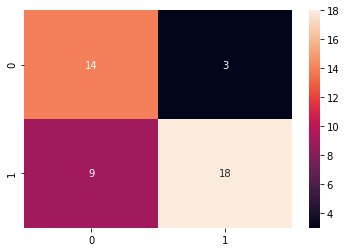

In [7]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(textos[:, 0]).todense()
X = MinMaxScaler().fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="discretize",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(cosine_distances(X))

pred = clustering.labels_
df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True)
plt.show()

### Supervised Learning

Parcialmente baseado no paper: [Towards detecting influenza epidemics by analyzing Twitter messages](https://dl.acm.org/doi/pdf/10.1145/1964858.1964874)

In [8]:
classifiers = [
    LogisticRegression(
        random_state=0,
        n_jobs=-1
    ), 
    RidgeClassifier(
        max_iter=500,
        random_state=0,
    ),
    SGDClassifier(
        random_state=0,
        n_jobs=-1
    ), 
    SVC(
        kernel="linear",
        random_state=0
    )
]

validacoes = []
for Vectorizer in [CountVectorizer, TfidfVectorizer]:
    for Norm in [MinMaxScaler, StandardScaler, None]:
        for ngram_range in [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3)]:
            vectorizer = Vectorizer(ngram_range=ngram_range)
            X = vectorizer.fit_transform(textos[:, 0]).todense()
            norm_name = None
            if Norm:
                norm_name = Norm.__name__
                X = Norm().fit_transform(X)
            y = textos[:, 1].astype(np.int).ravel()

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
            for Classifier in classifiers:
                clf = Classifier.fit(X_train, y_train)
                pred = clf.predict(X_test)

                acc = round(accuracy_score(pred, y_test) * 100, 2)
                f1 = round(f1_score(pred, y_test) * 100, 2)
                validacoes.append((
                    vectorizer.__class__.__name__,
                    norm_name,
                    ngram_range,
                    clf.__class__.__name__,
                    acc, 
                    f1
                ))

In [9]:
columns = ["Vectorizer", "Scaler", "NGram", "Classifier", "Accuracy", "F1"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "Vectorizer", "NGram"], ascending=False)
df.head(25)

,Vectorizer,Scaler,NGram,Classifier,Accuracy,F1
82,TfidfVectorizer,StandardScaler,"(1, 1)",SGDClassifier,71.43,81.82
22,CountVectorizer,StandardScaler,"(1, 1)",SGDClassifier,71.43,81.82
98,TfidfVectorizer,StandardScaler,"(3, 3)",SGDClassifier,64.29,78.26
94,TfidfVectorizer,StandardScaler,"(2, 3)",SGDClassifier,64.29,78.26
90,TfidfVectorizer,StandardScaler,"(1, 3)",SGDClassifier,64.29,78.26
86,TfidfVectorizer,StandardScaler,"(1, 2)",SGDClassifier,64.29,78.26
38,CountVectorizer,StandardScaler,"(3, 3)",SGDClassifier,64.29,78.26
34,CountVectorizer,StandardScaler,"(2, 3)",SGDClassifier,64.29,78.26
30,CountVectorizer,StandardScaler,"(1, 3)",SGDClassifier,64.29,78.26
26,CountVectorizer,StandardScaler,"(1, 2)",SGDClassifier,64.29,78.26


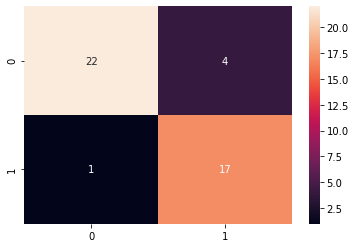

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
X = vectorizer.fit_transform(textos[:, 0]).todense()
X = StandardScaler().fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = SGDClassifier(
    random_state=0,
    n_jobs=-1
).fit(X_train, y_train)
pred = clf.predict(X)

df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True)
plt.show()